In [1]:
import numpy as np
import math
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.pyplot as plt
import json
import pandas as pd
import multiprocessing
from sklearn import metrics
from tqdm import tqdm
import geopy.distance
import geopandas as gpd
import matplotlib
import matplotlib.cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import geoplot as gplt
import geoplot.crs as gcrs
import contextily as ctx
from time import time
from datetime import datetime, timedelta 

import warnings
warnings.filterwarnings("ignore")

import utils

In [2]:
def saveFIG(filename='tmp.pdf'):
    import pylab as plt
    
    plt.subplots_adjust(
        top=1, 
        bottom=0, 
        right=1, 
        left=0, 
        hspace=0, 
        wspace=0)

    plt.margins(0, 0)
    
    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(filename, dpi=300, bbox_inches=0, transparent=True) 
    return

In [3]:
barTitleSize, barTickerSize = 20, 18
barWidth, barHeight = 1.4, 1.76
markerSize = 60

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.cm.get_cmap('jet')
cmap1 = truncate_colormap(cmap, 0.1, 0.8)
cmap2 = truncate_colormap(cmap.reversed(), 0.1, 0.8)
mcolor1 = 'blue'
mcolor2 = 'brown'

In [5]:
def lighten_color(color, amount=0.5):
    
    """
    By Ian Hincks from stack overflow
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [6]:
lighten_ratio = .2

## Weather

In [ ]:
df = pd.read_csv('../simulation_nncomput/data/sim_Weather_best_.csv.gz', compression='gzip')
datetime_range = pd.date_range(start='2019-01-01', end='2019-12-31', freq='12H')

def get_time(time):
    
    """
    change a datetime to date plus an hour range.
    If hour is 0: 0-12;
    If hour is 12: 12-24.
    """
    
    hour = time.hour
    date = time.strftime('%Y-%m-%d')
    
    if hour == 0:
        time_str = '{} 00:00-12:00'.format(date)
    else:
        time_str = '{} 12:00-24:00'.format(date)
    
    return time_str

lat_min, lat_max = df.lat1.min(), df.lat2.max()
lon_min, lon_max = df.lon1.min(), df.lon2.max()
print(f'lat = ({lat_min:.3f}, {lat_max:.3f})')
print(f'lon = ({lon_min:.3f}, {lon_max:.3f})')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent.str.contains('America')]
world = world[world.continent != 'South America']
world = world[world.name != 'Iceland']
world = world[world.name != 'Greenland']
world_ = world.to_crs(epsg=3857)

In [ ]:
day = 101
time = get_time(datetime_range[day])
print(time)

Z, Z_plot = 0.012, 0.012
parameters = {'prec': {}, 'winter': {}}
for var in ['prec', 'winter']:
    types = [var]
    fn, tp, fp, ppv, sens, lon_, lat_, int_plot, int_real, dfG = utils.get_prediction(
        df,
        day,
        types,
        lat_min,
        lat_max,
        lon_min,
        lon_max,
        radius=5,
        sigma=5,
        detail=.1,
        miles=20,
        Z=Z)

    print('day={}, {}: fp={}, tp={}, fn={}; ppv={:.3f}, sens={:.3f}'
          .format(day, var, fp, tp, fn, ppv, sens))

    int_plot = np.multiply(int_plot, (int_plot > Z_plot))
    int_ = (1. / int_plot.max()) * int_plot
    
    parameters[var].update({
        'fp': fp, 'tp': tp, 'fn': fn,
        'ppv': ppv, 'sens': sens,
        'lon': lon_, 'lat': lat_,
        'int': int_, 'df': dfG
    })

In [ ]:
parameters['prec']['cmap'] = cmap2
parameters['prec']['mcolor'] = mcolor2
parameters['winter']['cmap'] = cmap1
parameters['winter']['mcolor'] = mcolor1

xlim = [-1.45e7, -0.72e7] ###IXC
ylim = [.27e7, .63e7] ###IXC
height_width_ratio = (ylim[1] - ylim[0]) / (xlim[1] - xlim[0])
width = 16
height = width * height_width_ratio
fig = plt.figure(figsize=[width, height])

var_title_map = {
    'prec': 'Precipitation',
    'winter': 'Winter'
}


for var in ['prec', 'winter']:

    fp, tp, fn = parameters[var]['fp'], parameters[var]['tp'], parameters[var]['fn']
    lon_, lat_ = parameters[var]['lon'], parameters[var]['lat']
    int_, dfG = parameters[var]['int'], parameters[var]['df']

    dfG['Latitude'] = (dfG.lat1 + dfG.lat2) / 2
    dfG['Longitude'] = (dfG.lon1 + dfG.lon2) / 2
    dfG_ = dfG[['Latitude','Longitude']]
    GND = gpd.GeoDataFrame(
        dfG_, 
        geometry=gpd.points_from_xy(dfG_.Longitude, dfG_.Latitude))
    GND.crs= {'init' :'epsg:4326'}
    GND = GND.to_crs(epsg=3857)

    Longitude = []
    Latitude = []
    density = []
    for row in tqdm(np.arange(0,len(int_))):
        for col in np.arange(0,len(int_[row])):
            if int_[row, col] > 0:
                Longitude = np.append(Longitude,lon_[row,col])
                Latitude = np.append(Latitude,lat_[row,col])
                density = np.append(density,int_[row,col])
    
    df_density=pd.DataFrame(data={
        'Longitude': Longitude, 
        'Latitude': Latitude, 
        'density':density})
    
    wdf = gpd.GeoDataFrame(
        df_density, 
        geometry=gpd.points_from_xy(df_density.Longitude, df_density.Latitude))
    wdf.crs= {'init' :'epsg:4326'}
    wdf = wdf.to_crs(epsg=3857)

    ax = fig.gca()
    ax = world_.plot(ax=ax, edgecolor='w', facecolor=None, alpha=.01)
    ax = wdf.plot(
        ax=ax,
        column='density',
        edgecolor='w',
        linewidth=0,
        cmap=parameters[var]['cmap'],
        alpha=.1, 
        zorder=5)

    ax=GND.plot(
        ax=ax, 
        marker='o',
        lw=2,
        edgecolor=parameters[var]['mcolor'],
        color=lighten_color(parameters[var]['mcolor'], lighten_ratio), 
        markersize=40, 
        zorder=10)

    ctx.add_basemap(ax,source=ctx.sources.ST_TONER_BACKGROUND) ###IXC
    ax.set_xlim(*xlim) 
    ax.set_ylim(*ylim)

# ================== Add bars of FN, TP, FP ==============START

width_ratio = barWidth / width
height_ratio = barHeight / height
parameters['winter']['bar_location'] = [0.05, 0.15, width_ratio, height_ratio]
parameters['prec']['bar_location'] = [0.875, 0.15, width_ratio, height_ratio]

for var in ['winter', 'prec']:
    cmap = parameters[var]['cmap']
    bar_location = parameters[var]['bar_location']
    bar_data = [
        parameters[var]['fn'], 
        parameters[var]['tp'], 
        parameters[var]['fp']
    ]
#     cmap = matplotlib.cm.get_cmap(cmap)
#     color = cmap(.5)
    ax2 = plt.gcf().add_axes(bar_location)
    ax2.patch.set_alpha(0)

    ax2.bar(
        ['FN','TP','FP'],
        bar_data,
        color=parameters[var]['mcolor'],
        lw=0,
        zorder=20,
        alpha=.8)

    ax2.spines['bottom'].set_color('w')
    ax2.spines['top'].set_color('w') 
    ax2.spines['right'].set_visible(False) 
    ax2.spines['left'].set_visible(False) 
    ax2.tick_params(axis='x', colors='w', pad=8)
    ax2.tick_params(axis='y', colors='w')
    
    ax2.set_title(var_title_map[var], color='w', fontdict={'fontsize': barTitleSize, 'fontweight': 'bold'})
    ttl = ax2.title
    ttl.set_position([.5, 1.05])
    ax2.grid(True)

    for label in ax2.get_xticklabels():
        label.set_color('w')
        label.set_fontsize(barTickerSize)
        label.set_fontweight('bold')

    for label in ax2.get_yticklabels():
        label.set_color('w')
        label.set_fontsize(barTickerSize)
        label.set_fontweight('bold')

    ax2.tick_params(axis=u'both', which=u'both',length=0)
# ================== Add bars of FN, TP, FP ==============END

ax.axis('off')
saveFIG('selected_Weather_{}.pdf'.format(day))
# saveFIG('/home/yihuang/Documents/TEX/pub_nncomput_/tex/datafiles_app_2/figures/selected_Weather_{}.pdf'.format(day))
saveFIG('/Users/yhuang10/Documents/TEX/pub_nncomput_/tex/datafiles_app_2/figures/selected_Weather_{}.pdf'.format(day))

## Earthquake

In [ ]:
df = pd.read_csv('../simulation_nncomput/data/sim_EQ_current_75.csv')

datetime_range = pd.date_range(start='2009-01-01', end='2020-08-21', freq='3D')
def get_time_label(time):
    time1 = time + timedelta(days=2)
    time_label = '{} to {}'.format(time.strftime('%Y-%m-%d'), time1.strftime('%Y-%m-%d'))
    return time_label

lat_min, lat_max = df.lat1.min(), df.lat2.max()
lon_min, lon_max = df.lon1.min(), df.lon2.max()
print(f'lat = ({lat_min:.3f}, {lat_max:.3f})')
print(f'lon = ({lon_min:.3f}, {lon_max:.3f})')

In [ ]:
day = 1349
time = get_time_label(datetime_range[day-1])
print(time)

Z, Z_plot = 0.04, 0.04
parameters = {'prec': {}, 'winter': {}}
fn, tp, fp, ppv, sens, lon_, lat_, int_plot, int_real, dfG = utils.get_prediction(
    df,
    day,
    ['VAR'],
    lat_min,
    lat_max,
    lon_min,
    lon_max,
    radius=12,
    sigma=3.5,
    detail=1.2,
    miles=30,
    Z=Z)

int_plot = np.multiply(int_plot, (int_plot > Z_plot))
int_ = (1. / int_plot.max()) * int_plot

print('fp={}, tp={}, fn={}; ppv={:.3f}, sens={:.3f}'.format(fp, tp, fn, ppv, sens))

In [ ]:
xlim = [-1.5e7, 2e7] ###IXC
ylim = [-.8e7, .8e7] ###IXC

height_width_ratio = (ylim[1] - ylim[0]) / (xlim[1] - xlim[0])
width = 16
height = width * height_width_ratio

dfG['Latitude'] = (dfG.lat1 + dfG.lat2) / 2
dfG['Longitude'] = (dfG.lon1 + dfG.lon2) / 2
dfG_ = dfG[['Latitude','Longitude']]
GND = gpd.GeoDataFrame(
    dfG_, 
    geometry=gpd.points_from_xy(dfG_.Longitude, dfG_.Latitude))
GND.crs = {'init' :'epsg:4326'}
GND = GND.to_crs(epsg=3857)

Longitude = []
Latitude = []
density = []
for row in tqdm(np.arange(0,len(int_))):
    for col in np.arange(0,len(int_[row])):
        if int_[row, col] > 0:
            Longitude = np.append(Longitude,lon_[row,col])
            Latitude = np.append(Latitude,lat_[row,col])
            density = np.append(density,int_[row,col])

df_density = pd.DataFrame(data={
            'Longitude': Longitude, 
            'Latitude': Latitude, 
            'density':density})
    
wdf = gpd.GeoDataFrame(
    df_density, 
    geometry=gpd.points_from_xy(df_density.Longitude, df_density.Latitude))
wdf.crs = {'init' :'epsg:4326'}
wdf = wdf.to_crs(epsg=3857)

fig = plt.figure(figsize=(width, height))
ax = fig.gca()
ax.set_xlim(*xlim)
ax.set_ylim(*ylim) 

ax = wdf.plot(
    ax=ax,
    column='density',
    edgecolor='w',
    linewidth=0,
    cmap='jet',
    alpha=.8)

ax = GND.plot(
    ax=ax, 
    marker='o', 
    lw=2, 
    edgecolor='red', 
    color=lighten_color('red', lighten_ratio), 
    markersize=80)

ctx.add_basemap(ax, source=ctx.sources.ST_TONER_BACKGROUND) ###IXC

width_ratio = barWidth / width
height_ratio = barHeight / height
ax2 = plt.gcf().add_axes([0.06, 0.12, width_ratio, height_ratio])
ax2.patch.set_alpha(0)

ax2.grid(True)
ax2.bar(
    ['FN','TP','FP'],
    [fn, tp, fp],
    color='red',
    lw=0,
    zorder=2,
    alpha=.9)

ax2.spines['bottom'].set_color('w')
ax2.spines['top'].set_color('w') 
ax2.spines['right'].set_visible(False) 
ax2.spines['left'].set_visible(False) 
ax2.tick_params(axis='x', colors='w', pad=8)
ax2.tick_params(axis='y', colors='w')
        
for label in ax2.get_xticklabels():
    label.set_color('w')
    label.set_fontsize(barTickerSize)
    label.set_fontweight('bold')

for label in ax2.get_yticklabels():
    label.set_color('w')
    label.set_fontsize(barTickerSize)
    label.set_fontweight('bold')

ax2.tick_params(axis=u'both', which=u'both',length=0)

ax.axis('off')
saveFIG('selected_Earthquake_{}.pdf'.format(day))
# saveFIG('/home/yihuang/Documents/TEX/pub_nncomput_/tex/datafiles_app_2/figures/selected_Earthquake_{}.pdf'.format(day))
saveFIG('/Users/yhuang10/Documents/TEX/pub_nncomput_/tex/datafiles_app_2/figures/selected_Earthquake_{}.pdf'.format(day))

## Atlanta

In [7]:
df = pd.read_csv('../simulation_nncomput/data/sim_Crime_Atlanta_best_.csv.gz', compression='gzip')

datetime_range = pd.date_range(start='2017-01-01', end='2019-12-31', freq='2D')
def get_time_label(time):
    time1 = time + timedelta(days=1)
    time_label = '{} to {}'.format(time.strftime('%Y-%m-%d'), time1.strftime('%Y-%m-%d'))
    return time_label
get_time_label(datetime_range[80])

# ======================== Only for Atlanta ========================
# Only Atlanta has ocrimes as source
name_map = {
    'pcrimes': 'property',
    'vcrimes': 'violent',
    'ocrimes': 'ocrimes',
    'ALL': 'ALL'
}
df['source'] = df.source.apply(lambda x: name_map[x])
df['target'] = df.target.apply(lambda x: name_map[x])

lat_min, lat_max = df.lat1.min(), df.lat2.max()
lon_min, lon_max = df.lon1.min(), df.lon2.max()
print(f'lat = ({lat_min:.3f}, {lat_max:.3f})')
print(f'lon = ({lon_min:.3f}, {lon_max:.3f})')

lat = (33.654, 33.856)
lon = (-84.536, -84.311)


In [8]:
day = 58
time = get_time_label(datetime_range[day])
print(time)

Z, Z_plot = 0.013, 0.013 
parameters = {'property': {}, 'violent': {}}
for var in ['property', 'violent']:
    types = [var]
    fn, tp, fp, ppv, sens, lon_, lat_, int_plot, int_, dfG = utils.get_prediction(
        df,
        day,
        types,
        lat_min,
        lat_max,
        lon_min,
        lon_max,
        radius=0.006,
        sigma=3.5,
        detail=.0006,
        miles=0.01,
        Z=0.013)

    print('day={}, {}: fp={}, tp={}, fn={}; ppv={:.3f}, sens={:.3f}'
          .format(day, var, fp, tp, fn, ppv, sens))
    
    int_plot = np.multiply(int_plot, (int_plot > Z_plot))
    int_ = (1. / int_plot.max()) * int_plot

    parameters[var].update({
        'fp': fp, 'tp': tp, 'fn': fn,
        'ppv': ppv, 'sens': sens,
        'lon': lon_, 'lat': lat_,
        'int': int_, 'df': dfG
    })

2017-04-27 to 2017-04-28
day=58, property: fp=5, tp=11, fn=8; ppv=0.688, sens=0.579
day=58, violent: fp=0, tp=7, fn=5; ppv=1.000, sens=0.583


100%|██████████| 357/357 [00:00<00:00, 3644.71it/s]


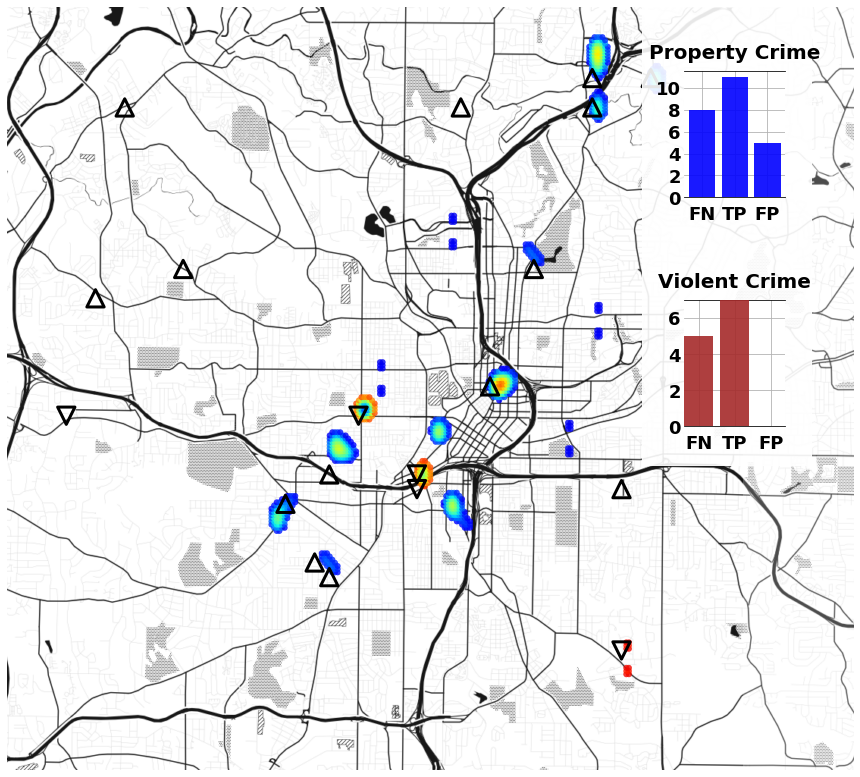

In [22]:
parameters['violent']['cmap'] = cmap2
parameters['violent']['bcolor'] = mcolor2
parameters['violent']['mcolor'] = 'k'
parameters['violent']['mtype'] = 'v'
parameters['property']['cmap'] = cmap1
parameters['property']['bcolor'] = mcolor1
parameters['property']['mcolor'] = 'k'
parameters['property']['mtype'] = '^'

xlim = [-9406250, -9384900]
ylim = [3987000, 4006250]
width_height_ratio = (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
height = 10.6
width = width_height_ratio * height
fig = plt.figure(figsize=(width, height))

var_title_map = {
    'property': 'Property Crime',
    'violent': 'Violent Crime'
}
for var in ['property', 'violent']:

    fp, tp, fn = parameters[var]['fp'], parameters[var]['tp'], parameters[var]['fn']
    lon_, lat_ = parameters[var]['lon'], parameters[var]['lat']
    int_, dfG = parameters[var]['int'], parameters[var]['df']

    dfG['Latitude'] = (dfG.lat1 + dfG.lat2) / 2
    dfG['Longitude'] = (dfG.lon1 + dfG.lon2) / 2
    dfG_ = dfG[['Latitude','Longitude']]
    GND = gpd.GeoDataFrame(
        dfG_, 
        geometry=gpd.points_from_xy(dfG_.Longitude, dfG_.Latitude))
    GND.crs= {'init' :'epsg:4326'}
    GND = GND.to_crs(epsg=3857)

    Longitude = []
    Latitude = []
    density = []
    for row in tqdm(np.arange(0,len(int_))):
        for col in np.arange(0,len(int_[row])):
            if int_[row, col] > 0:
                Longitude = np.append(Longitude,lon_[row,col])
                Latitude = np.append(Latitude,lat_[row,col])
                density = np.append(density,int_[row,col])

    df_density=pd.DataFrame(data={
        'Longitude': Longitude, 
        'Latitude': Latitude, 
        'density':density})

    wdf = gpd.GeoDataFrame(
        df_density, 
        geometry=gpd.points_from_xy(df_density.Longitude, df_density.Latitude))
    wdf.crs= {'init' :'epsg:4326'}
    wdf = wdf.to_crs(epsg=3857)

    ax = fig.gca()
    ax = wdf.plot(
        ax=ax,
        column='density',
        edgecolor='w',
        linewidth=0,
        cmap=parameters[var]['cmap'],
        alpha=.8, 
        zorder=5)

    ax=GND.plot(
        ax=ax, 
        marker=parameters[var]['mtype'],
        lw=3,
        # edgecolor='b',
        facecolors='none',
        edgecolor=parameters[var]['mcolor'],
        # color=lighten_color(parameters[var]['mcolor'], lighten_ratio), 
        markersize=300, 
        zorder=10)

    ctx.add_basemap(ax, source=ctx.sources.ST_TONER_BACKGROUND,alpha=.7)  ###IXC
    # A MUST-HAVE OR OTHERWISE THE DIMENSION OF THE PLOT ARE NOT UNIFORM
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)


# ================== Add bars of FN, TP, FP ==============START
width_ratio = barWidth / width
height_ratio = barHeight / height
parameters['property']['bar_location'] = [0.8, 0.75, width_ratio, height_ratio]
parameters['violent']['bar_location'] = [0.8, 0.45, width_ratio, height_ratio]

###IXC
plt.gcf().patches.extend([
    plt.Rectangle(
        (0.75, 0.4), 
        0.2, 0.6, 
        fill=True, 
        color='w', 
        alpha=0.9, 
        zorder=1,
        transform=fig.transFigure, 
        figure=plt.gcf())
])

for var in ['property', 'violent']:
    cmap = parameters[var]['cmap']
    bar_location = parameters[var]['bar_location']
    bar_data = [
        parameters[var]['fn'], 
        parameters[var]['tp'], 
        parameters[var]['fp']
    ]
    cmap = matplotlib.cm.get_cmap(cmap)
    color = cmap(.5)
    
    ax2 = plt.gcf().add_axes(bar_location, zorder=20) ###IXC
    ax2.patch.set_alpha(1) ###IXC
    ax2.set_facecolor("white") ###IXC
    
    ax2.bar(
        ['FN','TP','FP'],
        bar_data,
        color=parameters[var]['bcolor'],
        lw=0,
        zorder=20,
        alpha=.9)

    ax2.spines['bottom'].set_color('black')
    ax2.spines['top'].set_color('black') 
    ax2.spines['right'].set_visible(False) 
    ax2.spines['left'].set_visible(False) 
    ax2.tick_params(axis='x', colors='black', pad=8)
    ax2.tick_params(axis='y', colors='black')

    ax2.set_title(var_title_map[var], color='black', fontdict={'fontsize': barTitleSize, 'fontweight': 'bold'})
    ttl = ax2.title
    ttl.set_position([.5, 1.05])
    ax2.grid(True)

    for label in ax2.get_xticklabels():
        label.set_color('black')
        label.set_fontsize(barTickerSize)
        label.set_fontweight('bold')

    for label in ax2.get_yticklabels():
        label.set_color('black')
        label.set_fontsize(barTickerSize)
        label.set_fontweight('bold')

    ax2.tick_params(axis=u'both', which=u'both',length=0)
# ================== Add bars of FN, TP, FP ==============END

ax.axis('off')
saveFIG('selected_Atlanta_{}.pdf'.format(day))
# saveFIG('/home/yihuang/Documents/TEX/pub_nncomput_/tex/datafiles_app_2/figures/selected_Atlanta_{}.pdf'.format(day))
#saveFIG('/Users/yhuang10/Documents/TEX/pub_nncomput_/tex/datafiles_app_2/figures/selected_Atlanta_{}.pdf'.format(day))

## Chicago

In [27]:
df = pd.read_csv('../simulation_nncomput/data/sim_Crime_Chicago_best_.csv.gz', compression='gzip')

datetime_range = pd.date_range(start='2017-01-01', end='2019-04-30', freq='D')

# ========================= Only for Chicago ====================
name_map = {
    'VAR': 'arrest',
    'BURGLARY-THEFT-MOTOR_VEHICLE_THEFT': 'property',
    'HOMICIDE-ASSAULT-BATTERY': 'violent',
    'ALL': 'ALL'
}
df['source'] = df.source.apply(lambda x: name_map[x])
df['target'] = df.target.apply(lambda x: name_map[x])

lat_min, lat_max = df.lat1.min(), df.lat2.max()
lon_min, lon_max = df.lon1.min(), df.lon2.max()
print(f'lat = ({lat_min:.3f}, {lat_max:.3f})')
print(f'lon = ({lon_min:.3f}, {lon_max:.3f})')

lat = (41.655, 42.022)
lon = (-87.847, -87.527)


In [28]:
day = 85
time = datetime_range[day].date().strftime('%Y-%m-%d')
print(time)

Z, Z_plot = 0.015, 0.015

parameters = {'property': {}, 'violent': {}}
for var in ['property', 'violent']:
    types = [var]
    fn, tp, fp, ppv, sens, lon_, lat_, int_plot, int_, dfG = utils.get_prediction(
        df,
        day,
        types,
        lat_min,
        lat_max,
        lon_min,
        lon_max,
        radius=0.006,
        sigma=3.5,
        detail=.0006,
        miles=0.01,
        Z=0.015)

    print('day={}, {}: fp={}, tp={}, fn={}; ppv={:.3f}, sens={:.3f}'
          .format(day, var, fp, tp, fn, ppv, sens))
    
    int_plot = np.multiply(int_plot, (int_plot > Z_plot))
    int_ = (1. / int_plot.max()) * int_plot

    parameters[var].update({
        'fp': fp, 'tp': tp, 'fn': fn,
        'ppv': ppv, 'sens': sens,
        'lon': lon_, 'lat': lat_,
        'int': int_, 'df': dfG
    })
    

2017-03-27
day=85, property: fp=71, tp=133, fn=81; ppv=0.652, sens=0.621
day=85, violent: fp=32, tp=110, fn=78; ppv=0.775, sens=0.585


100%|██████████| 633/633 [00:00<00:00, 1267.61it/s]


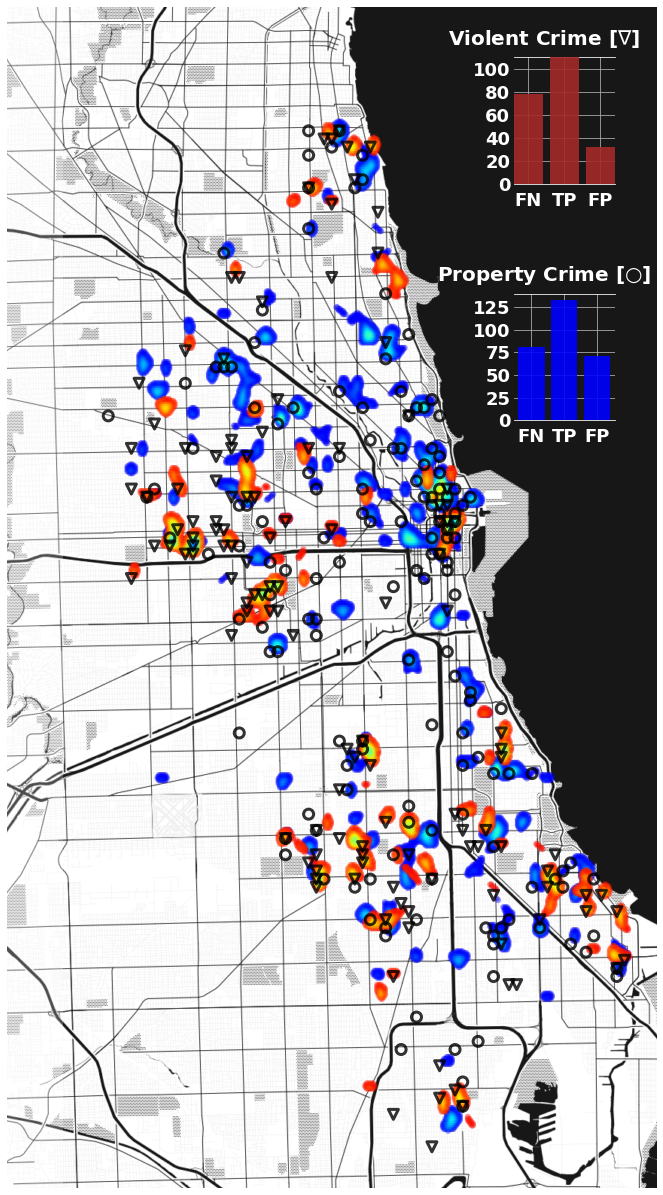

In [44]:
parameters['violent']['cmap'] = cmap2
parameters['violent']['bcolor'] = mcolor2
parameters['violent']['mcolor'] = 'k'
parameters['violent']['mtype'] = 'v'
parameters['property']['cmap'] = cmap1
parameters['property']['bcolor'] = mcolor1
parameters['property']['mcolor'] = 'k'
parameters['property']['mtype'] = 'o'

xlim = [-9777000, -9744000]
ylim = [5110000, 5170000]
width_height_ratio = (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
height = 16.4
width = width_height_ratio * height
fig = plt.figure(figsize=(width, height))


var_title_map = {
    'property': 'Property Crime' + ' ['+ r"$\bigcirc$"+ ']',
    'violent': 'Violent Crime'+ ' ['+r"$\nabla$" + ']'
}
for var in ['property', 'violent']:

    fp, tp, fn = parameters[var]['fp'], parameters[var]['tp'], parameters[var]['fn']
    lon_, lat_ = parameters[var]['lon'], parameters[var]['lat']
    int_, dfG = parameters[var]['int'], parameters[var]['df']

    dfG['Latitude'] = (dfG.lat1 + dfG.lat2) / 2
    dfG['Longitude'] = (dfG.lon1 + dfG.lon2) / 2
    dfG_ = dfG[['Latitude','Longitude']]
    GND = gpd.GeoDataFrame(
        dfG_, 
        geometry=gpd.points_from_xy(dfG_.Longitude, dfG_.Latitude))
    GND.crs= {'init' :'epsg:4326'}
    GND = GND.to_crs(epsg=3857)

    Longitude = []
    Latitude = []
    density = []
    for row in tqdm(np.arange(0,len(int_))):
        for col in np.arange(0,len(int_[row])):
            if int_[row, col] > 0:
                Longitude = np.append(Longitude,lon_[row,col])
                Latitude = np.append(Latitude,lat_[row,col])
                density = np.append(density,int_[row,col])

    df_density=pd.DataFrame(data={
        'Longitude': Longitude, 
        'Latitude': Latitude, 
        'density':density})

    wdf = gpd.GeoDataFrame(
        df_density, 
        geometry=gpd.points_from_xy(df_density.Longitude, df_density.Latitude))
    wdf.crs= {'init' :'epsg:4326'}
    wdf = wdf.to_crs(epsg=3857)

    ax = fig.gca()
    ax = wdf.plot(
        ax=ax,
        column='density',
        edgecolor='w',
        linewidth=0,
        cmap=parameters[var]['cmap'],
        alpha=.4, 
        zorder=5)

    ax=GND.plot(
        ax=ax, 
        marker=parameters[var]['mtype'],
        lw=3,
        facecolors='none',
        alpha=.8,
        edgecolor=parameters[var]['mcolor'], 
        # color=lighten_color(parameters[var]['mcolor'], lighten_ratio), 
        markersize=100, 
        zorder=10)

    ctx.add_basemap(ax, source=ctx.sources.ST_TONER_BACKGROUND,alpha=.7)
    # A MUST-HAVE OR OTHERWISE THE DIMENSION OF THE PLOT ARE NOT UNIFORM
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

arr_lena = mpimg.imread('/home/ishanu/Dropbox/scratch_/icons/rain.pn')
imagebox = OffsetImage(arr_lena, zoom=0.2)
ab = AnnotationBbox(imagebox, (0.4, 0.6))
ax.add_artist(ab)
    

# ================== Add bars of FN, TP, FP ==============START
width_ratio = barWidth / width
height_ratio = barHeight / height
parameters['property']['bar_location'] = [0.78, 0.65, width_ratio, height_ratio]
parameters['violent']['bar_location'] = [0.78, 0.85, width_ratio, height_ratio]

for var in ['property', 'violent']:
    cmap = parameters[var]['cmap']
    bar_location = parameters[var]['bar_location']
    bar_data = [
        parameters[var]['fn'], 
        parameters[var]['tp'], 
        parameters[var]['fp']
    ]
    cmap = matplotlib.cm.get_cmap(cmap)
    ax2 = plt.gcf().add_axes(bar_location)
    ax2.patch.set_alpha(0)

    ax2.bar(
        ['FN','TP','FP'],
        bar_data,
        color=parameters[var]['bcolor'],
        lw=0,
        zorder=20,
        alpha=.9)

    ax2.spines['bottom'].set_color('w')
    ax2.spines['top'].set_color('w') 
    ax2.spines['right'].set_visible(False) 
    ax2.spines['left'].set_visible(False) 
    ax2.tick_params(axis='x', colors='w', pad=8)
    ax2.tick_params(axis='y', colors='w')

    ax2.set_title(var_title_map[var], color='w', fontdict={'fontsize': barTitleSize, 'fontweight': 'bold'})
    ttl = ax2.title
    ttl.set_position([.3, 1.05])  ##IXCUPDATE
    ax2.grid(True)

    for label in ax2.get_xticklabels():
        label.set_color('w')
        label.set_fontsize(barTickerSize)
        label.set_fontweight('bold')

    for label in ax2.get_yticklabels():
        label.set_color('w')
        label.set_fontsize(barTickerSize)
        label.set_fontweight('bold')

    ax2.tick_params(axis=u'both', which=u'both',length=0)
# ================== Add bars of FN, TP, FP ==============END

ax.axis('off')
saveFIG('selected_Chicago_{}.pdf'.format(day))
# saveFIG('/home/yihuang/Documents/TEX/pub_nncomput_/tex/datafiles_app_2/figures/selected_Chicago_{}.pdf'.format(day))
#saveFIG('/Users/yhuang10/Documents/TEX/pub_nncomput_/tex/datafiles_app_2/figures/selected_Chicago_{}.pdf'.format(day))

## Philadelphia

In [23]:
df = pd.read_csv('../simulation_nncomput/data/sim_Crime_Philadelphia_best_.csv.gz', compression='gzip')
datetime_range = pd.date_range(start='2017-01-01', end='2019-04-30', freq='D')

name_map = {
    'pcrimes': 'property',
    'vcrimes': 'violent',
    'ALL': 'ALL'
}
df['source'] = df.source.apply(lambda x: name_map[x])
df['target'] = df.target.apply(lambda x: name_map[x])

lat_min, lat_max = df.lat1.min(), df.lat2.max()
lon_min, lon_max = df.lon1.min(), df.lon2.max()
print(f'lat = ({lat_min:.3f}, {lat_max:.3f})')
print(f'lon = ({lon_min:.3f}, {lon_max:.3f})')

lat = (39.884, 40.122)
lon = (-75.274, -74.957)


In [24]:
day = 80
time = datetime_range[day].date().strftime('%Y-%m-%d')
print(time)

Z, Z_plot = 0.015, 0.015
parameters = {'property': {}, 'violent': {}}
for var in ['property', 'violent']:
    types = [var]
    fn, tp, fp, ppv, sens, lon_, lat_, int_plot, int_, dfG = utils.get_prediction(
        df,
        day,
        types,
        lat_min,
        lat_max,
        lon_min,
        lon_max,
        radius=0.006,
        sigma=3.5,
        detail=.0006,
        miles=0.01,
        Z=0.015)

    print('day={}, {}: fp={}, tp={}, fn={}; ppv={:.3f}, sens={:.3f}'
          .format(day, var, fp, tp, fn, ppv, sens))
    
    int_plot = np.multiply(int_plot, (int_plot > Z_plot))
    int_ = (1. / int_plot.max()) * int_plot

    parameters[var].update({
        'fp': fp, 'tp': tp, 'fn': fn,
        'ppv': ppv, 'sens': sens,
        'lon': lon_, 'lat': lat_,
        'int': int_, 'df': dfG
    })

2017-03-22
day=80, property: fp=22, tp=47, fn=26; ppv=0.681, sens=0.644
day=80, violent: fp=5, tp=21, fn=6; ppv=0.808, sens=0.778


100%|██████████| 417/417 [00:00<00:00, 1837.06it/s]


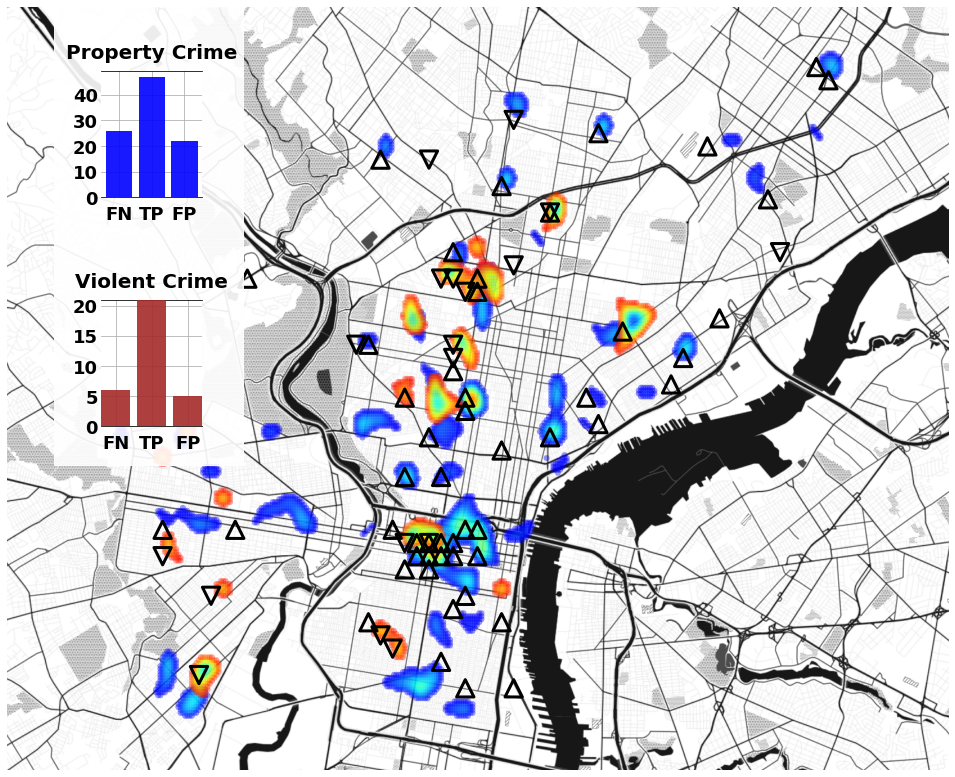

In [26]:
parameters['violent']['cmap'] = cmap2
parameters['violent']['bcolor'] = mcolor2
parameters['violent']['mcolor'] = 'k'
parameters['violent']['mtype'] = 'v'
parameters['property']['cmap'] = cmap1
parameters['property']['bcolor'] = mcolor1
parameters['property']['mcolor'] = 'k'
parameters['property']['mtype'] = '^'

xlim = [-8380000, -8352000]
ylim = [4852300, 4875000]
width_height_ratio = (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
height = 10.6
width = width_height_ratio * height
fig = plt.figure(figsize=(width, height))

var_title_map = {
    'property': 'Property Crime',
    'violent': 'Violent Crime'
}
for var in ['property', 'violent']:

    fp, tp, fn = parameters[var]['fp'], parameters[var]['tp'], parameters[var]['fn']
    lon_, lat_ = parameters[var]['lon'], parameters[var]['lat']
    int_, dfG = parameters[var]['int'], parameters[var]['df']

    dfG['Latitude'] = (dfG.lat1 + dfG.lat2) / 2
    dfG['Longitude'] = (dfG.lon1 + dfG.lon2) / 2
    dfG_ = dfG[['Latitude','Longitude']]
    GND = gpd.GeoDataFrame(
        dfG_, 
        geometry=gpd.points_from_xy(dfG_.Longitude, dfG_.Latitude))
    GND.crs= {'init' :'epsg:4326'}
    GND = GND.to_crs(epsg=3857)

    Longitude = []
    Latitude = []
    density = []
    for row in tqdm(np.arange(0,len(int_))):
        for col in np.arange(0,len(int_[row])):
            if int_[row, col] > 0:
                Longitude = np.append(Longitude,lon_[row,col])
                Latitude = np.append(Latitude,lat_[row,col])
                density = np.append(density,int_[row,col])

    df_density=pd.DataFrame(data={
        'Longitude': Longitude, 
        'Latitude': Latitude, 
        'density':density})

    wdf = gpd.GeoDataFrame(
        df_density, 
        geometry=gpd.points_from_xy(df_density.Longitude, df_density.Latitude))
    wdf.crs= {'init' :'epsg:4326'}
    wdf = wdf.to_crs(epsg=3857)

    ax = fig.gca()
    ax = wdf.plot(
        ax=ax,
        column='density',
        edgecolor='w',
        linewidth=0,
        cmap=parameters[var]['cmap'],
        alpha=.4, 
        zorder=5)

    ax=GND.plot(
        ax=ax, 
        marker=parameters[var]['mtype'],
        lw=3,
        facecolors='none',
        edgecolor=parameters[var]['mcolor'],
        # color=lighten_color(parameters[var]['mcolor'], lighten_ratio), 
        markersize=300, 
        zorder=10)

    ctx.add_basemap(ax, source=ctx.sources.ST_TONER_BACKGROUND,alpha=.7)
    # A MUST-HAVE OR OTHERWISE THE DIMENSION OF THE PLOT ARE NOT UNIFORM
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)


# ================== Add bars of FN, TP, FP ==============START
width_ratio = barWidth / width
height_ratio = barHeight / height
parameters['property']['bar_location'] = [0.1, 0.75, width_ratio, height_ratio]
parameters['violent']['bar_location'] = [0.1, 0.45, width_ratio, height_ratio]


###IXC
plt.gcf().patches.extend([
    plt.Rectangle(
        (0.05, 0.4), 
        0.2, 0.6, 
        fill=True, 
        color='w', 
        alpha=0.9, 
        zorder=1,
        transform=fig.transFigure, 
        figure=plt.gcf())
])

for var in ['property', 'violent']:
    cmap = parameters[var]['cmap']
    bar_location = parameters[var]['bar_location']
    bar_data = [
        parameters[var]['fn'], 
        parameters[var]['tp'], 
        parameters[var]['fp']
    ]
    cmap = matplotlib.cm.get_cmap(cmap)
    color = cmap(.5)
    
    ax2 = plt.gcf().add_axes(bar_location, zorder=20) ###IXC
    ax2.patch.set_alpha(1) ###IXC
    ax2.set_facecolor("white")  ###IXC    
    
    ax2.bar(
        ['FN','TP','FP'],
        bar_data,
        color=parameters[var]['bcolor'],
        lw=0,
        zorder=20,
        alpha=.9)

    ax2.spines['bottom'].set_color('black')
    ax2.spines['top'].set_color('black') 
    ax2.spines['right'].set_visible(False) 
    ax2.spines['left'].set_visible(False) 
    ax2.tick_params(axis='x', colors='black', pad=8)
    ax2.tick_params(axis='y', colors='black')

    ax2.set_title(var_title_map[var], color='black', fontdict={'fontsize': barTitleSize, 'fontweight': 'bold'})
    ttl = ax2.title
    ttl.set_position([.5, 1.05])
    ax2.grid(True)

    for label in ax2.get_xticklabels():
        label.set_color('black')
        label.set_fontsize(barTickerSize)
        label.set_fontweight('bold')

    for label in ax2.get_yticklabels():
        label.set_color('black')
        label.set_fontsize(barTickerSize)
        label.set_fontweight('bold')

    ax2.tick_params(axis=u'both', which=u'both',length=0)
# ================== Add bars of FN, TP, FP ==============END

ax.axis('off')
saveFIG('selected_Philadelphia_{}.pdf'.format(day))
# saveFIG('/home/yihuang/Documents/TEX/pub_nncomput_/tex/datafiles_app_2/figures/selected_Philadelphia_{}.pdf'.format(day))
#saveFIG('/Users/yhuang10/Documents/TEX/pub_nncomput_/tex/datafiles_app_2/figures/selected_Philadelphia_{}.pdf'.format(day))